# Lecture 10: From dense to sparse linear algebra

## Recap of the previous lecture
- Randomized matmul
- Hutchinson trace estimator
- Randomized SVD
- Karcmarz

## Plan of todays lecture

- Simple topic in parallel computing in NLA (on the matvec example)
- Sparse matrix part (with a separate plan)

## Large scale dense matrices

- If the size of the dense matrix is huge, then it can not be stored in memory
- Possible options
    - This matrix is **structured**, e.g. block Toeplitz with Toeptitz blocks (next lectures). Then the compressed storage is possible
    - For unstructured dense matrices **distributed memory** helps
    - MPI for processing distributed storing matrices

### Distributed memory and MPI

- Split matrix into blocks and store them on different machines
- Every machine has its own address space and can not damage data on other machines
- In this case machines communicate with each other to aggregate results of computations
- [MPI (Message Passing Interface)](https://en.wikipedia.org/wiki/Message_Passing_Interface) is a standard for parallel computing in distributed memory



### Example: matrix-by-vector product

- Assume you want to compute $Ax$ and matrix $A$ can not be stored in available memory
- Then you can split it on blocks and distribute blocks on separate machines
- Possible strategies
    - 1D blocking splits only rows on blocks
    - 2D blocking splits both rows and columns

#### 1D blocking scheme
<img src="1d_block.jpg">

#### Total time of computing matvec with 1D blocking

- Each machine has $n / p $ complete rows and $n / p$ elements of vector
- Total operations are $n^2 / p$
- Total time for sending and writing data are $t_s \log p + t_w n$, where $t_s$ time unit for sending and $t_w$ time unit for writing

#### 2D blocking scheme

<img src="2d_block.png" width=400>

#### Total time of computing matvec with 2D blocking

- Each machine has $n / \sqrt{p} $ size block and $n / \sqrt{p}$ elements of vector
- Total operations are $n^2 / p$
- Total time for sending and writing data are approximately $t_s \log p + t_w (n/\sqrt{p}) \log p$, where $t_s$ time unit for sending and $t_w$ time unit for writing

### Packages supported distributed storage

- [ScaLAPACK](http://www.netlib.org/scalapack/)
- [Trilinos](https://trilinos.org/)

In Python you can use [mpi4py](https://mpi4py.readthedocs.io/en/stable/) for parallel programming of your algorithm.

- PyTorch supports distributed training and data storage, see details [here](https://pytorch.org/tutorials/intermediate/dist_tuto.html) 

### Summary on large unstructered matrix processing

- Distributed manner of storage
- MPI
- Packages that use parallel computations
- Different blocking strategies

## Sparse matrices intro

- For dense linear algebra problems, we are limited by the memory to store the full matrix, it is $N^2$ parameters.

- The class of **sparse** matrices where most of the elements are zero, allows us **at least** to store such matrices.

The question if we can:

- solve linear systems
- solve eigenvalue problems

with sparse matrices

## Plan for the next part of the lecture

Now we will talk about **sparse matrices**, where they arise, how we store them, how we operate with them.


- Formats: list of lists and compressed sparse row format, relation to graphs
- Matrix-by-vector product
- Parallell processing of sparse matrices 
- Fast direct solvers for Gaussian elimination (start)

## Applications of sparse matrices

Sparse matrices arise in:

- partial differential equations (PDE), mathematical modelling
- graphs mining, e.g. social networks analysis
- recommender systems
- wherever relations between objects are "sparse".

### Sparse matrices are ubiquitous in PDE

The simplest partial differential equation (PDE), called 

**Laplace equation**:  

$$
   \Delta T = \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = f(x,y), \quad x,y\in \Omega\equiv[0,1]^2,
$$

$$
    T_{\partial\Omega} = 0.
$$

#### Discretization

$$\frac{\partial^2 T}{\partial x^2} \approx \frac{T(x+h) + T(x-h) - 2T(x)}{h^2} + \mathcal{O}(h^2),$$

same for $\frac{\partial^2 T}{\partial y^2},$
and we get a linear system.  
    First, let us consider **one-dimensional case**:

After the discretization of the one-dimensional Laplace equation with Dirichlet boundary conditions we have

$$\frac{u_{i+1} + u_{i-1} - 2u_i}{h^2} = f_i,\quad i=1,\dots,N-1$$

$$ u_{0} = u_N = 0$$
or in the matrix form

$$ A u = f,$$
and (for $n = 5$)
$$A=-\frac{1}{h^2}\begin{bmatrix} 2 & -1 & 0 & 0 & 0\\ -1 & 2 & -1 & 0 &0 \\ 0 & -1 & 2& -1 & 0 \\ 0 & 0 & -1 & 2  &-1\\ 0 & 0 & 0 & -1 & 2 \end{bmatrix}$$

The matrix is **triadiagonal** and **sparse**  
(and also **Toeplitz**: all elements on the diagonal are the same)

#### Block structure in 2D
In two dimensions, we get equation of the form

$$-\frac{4u_{ij} -u_{(i-1)j} - u_{(i+1)j} - u_{i(j-1)}-u_{i(j+1)}}{h^2} = f_{ij},$$

or in the **Kronecker product form**  

$$\Delta_{2D} = \Delta_{1D} \otimes I + I \otimes \Delta_{1D},$$

where $\Delta_{1D}$ is a 1D Laplacian, and $\otimes$ is a **Kronecker product** of matrices. 

For matrices $A\in\mathbb{R}^{n\times m}$ and $B\in\mathbb{R}^{l\times k}$ its Kronecker product is defined as a block matrix of the form 

$$
   A\otimes B = \begin{bmatrix}a_{11}B & \dots & a_{1m}B \\ \vdots & \ddots & \vdots \\ a_{n1}B & \dots & a_{nm}B\end{bmatrix}\in\mathbb{R}^{nl\times mk}.
$$

In the block matrix form the 2D-Laplace matrix can be written in the following form:  

$$A = -\frac{1}{h^2}\begin{bmatrix} \Delta_1 + 2I & -I & 0 & 0 & 0\\ -I & \Delta_1 + 2I  & -I & 0 &0 \\ 0 & -I & \Delta_1 + 2I & -I & 0 \\ 0 & 0 & -I & \Delta_1 + 2I   &-I\\ 0 & 0 & 0 & -I & \Delta_1 + 2I \end{bmatrix}$$

##### Short list of Kronecker product properties

- It is bilinear
- $(A\otimes B) (C\otimes D) = AC \otimes BD$
- Let $\mathrm{vec}(X)$ be vectorization of matrix $X$ columnwise. Then 
$\mathrm{vec}(AXB) = (B^T \otimes A) \mathrm{vec}(X).$

### Sparse matrices help in computational graph theory

- Graphs are represented with adjacency matrix, which is usually sparse
- Numerical solution of graph theory problems are based on processing of this sparse matrix
    - Community detection and graph clustering
    - Learning to rank
    - Random walks
    - Others
- Example: probably the largest publicly available hyperlink graph consists of 3.5 billion web pages and 128 billion hyperlinks, more details see [here](http://webdatacommons.org/hyperlinkgraph/) 
- More medium scale graphs to test your algorithms are available in [Stanford Large Network Dataset Collection](https://snap.stanford.edu/data/)

### SuiteSpare matrix collection (formerly Florida sparse matrix collection)

More sparse matrices you can find in  [SuiteSparse matrix collection](https://sparse.tamu.edu/) which contains all sorts of matrices for different applications.

In [4]:
from IPython.display import IFrame
IFrame("http://yifanhu.net/GALLERY/GRAPHS/search.html", width=700, height=450)

### Sparse matrices and deep learning

- DNN has a lot of parameters
- Some of them may be redundant
- How to prune the parameters without significantly accuracy reduction?
- [Sparse variational dropout method](https://github.com/ars-ashuha/variational-dropout-sparsifies-dnn) leads to significantly sparse filters in DNN almost without accuracy decreasing: the idea of **pruning**

## Sparse matrix: construction

- We can create sparse matrix using **scipy.sparse** package (actually this is **not the best** sparse matrix package)

- We can go to really large sizes (at least, to store this matrix in the memory)

Please note the following functions
- Create sparse matrices with given diagonals ```spdiags```
- Kronecker product of sparse matrices ```kron```
- There is also overloaded arithmectics for sparse matrices

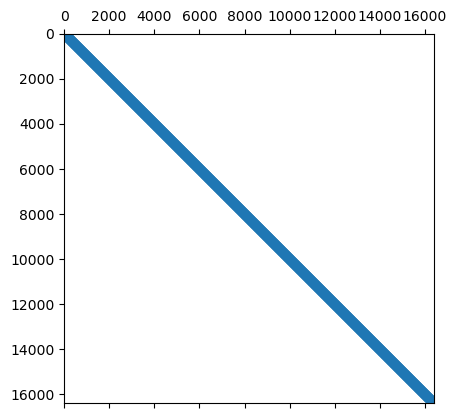

In [6]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse.linalg
%matplotlib inline
n = 128
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
plt.spy(A, aspect='equal', marker='.', markersize=5)

### Sparsity pattern 

- The ```spy``` command plots the sparsity pattern of the matrix: the $(i, j)$ pixel is drawn, if the corresponding matrix element is non-zero.

- Sparsity pattern is really important for the understanding the complexity of the sparse linear algebra algorithms.  

- Often, only the sparsity pattern is needed for the analysis of "how complex" the matrix is.

### Sparse matrix: definition

- The definition of "sparse matrix" is that the number of **non-zero elements** is much less than the total number of elements. 

- You can do the basic linear algebra operations (like solving linear systems at the first place) faster, than if working for with the full matrix.

## What we need to find out to see how it actually works

- **Question 1:** How to store the sparse matrix in memory?

- **Question 2:** How to multiply sparse matrix by vector fast?

- **Question 3:** How to solve linear systems with sparse matrices fast?

### Sparse matrix storage

There are many storage formats, important ones:

- COO (Coordinate format)
- LIL (Lists of lists)
- CSR (compressed sparse row)
- CSC (compressed sparse column)
- Block variants

In ```scipy``` there are constructors for each of these formats, e.g. 

```scipy.sparse.lil_matrix(A)```.

#### Coordinate format (COO)

The simplest format is to use **coordinate format** to represent the sparse matrix as positions and values of non-zero elements.

```python
i, j, val
```

where ```i, j``` are integer array of indices, ```val``` is the real array of matrix elements. <br>
So we need to store $3\cdot$ **nnz** elements, where **nnz** denotes number of nonzeroes in the matrix.

**Q:** What is good and what is bad in this format?

#### Main disadvantages

- It is not optimal in storage (why?)
- It is not optimal for matrix-by-vector product (why?)
- It is not optimal for removing elements as you must make **nnz** operations to find one element (this is good in LIL format)

First two disadvantages are solved by **compressed sparse row** (CSR) format.

#### Compressed sparse row (CSR)

In the CSR format a matrix is stored as 3 different arrays:

```python
ia, ja, sa
```

where:

- **ia** (row start) is an integer array of length $n+1$ 
- **ja** (column indices) is an integer array of length **nnz** 
-  **sa** (values) is an real-value array of length **nnz**

<img src="https://www.karlrupp.net/wp-content/uploads/2016/02/csr_storage_sparse_marix.png" width=60% />

So, we got $2\cdot{\bf nnz} + n+1$ elements.

### Sparse matrices in PyTorch and Tensorflow

- PyTorch supports sparse matrices stored in COO format
- Incompletre backward operation for these matrices, see summary [here](https://github.com/pytorch/pytorch/issues/9674)
- Tensorflow also supports sparse matrices in COO format
- The list of supported operations is [here](https://www.tensorflow.org/api_docs/python/tf/sparse) and gradient support is also limited

### CSR helps in sparse matrix by vector product (SpMV)

```python

   for i in range(n):
        
        for k in range(ia[i]:ia[i+1]):
            
            y[i] += sa[k] * x[ja[k]]
```

Let us do a short timing test

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
%matplotlib inline
n = 1024
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
B = coo_matrix(A)
%timeit A.dot(rhs)
%timeit B.dot(rhs)

3.24 ms ± 74.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.7 ms ± 379 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As you see, **CSR** is faster, and for more **unstructured patterns** the gain will be larger.

### Sparse matrices and efficiency

- Sparse matrices give complexity reduction.  
- But they are **not very good** for parallel/GPU implementation.  
- They do not give maximal efficiency due to **random data access**.  
- Typically, peak efficiency of $10\%-15\%$ is considered good.  

### Recall how we measure efficiency of linear algebra operations

The standard way to measure the efficiency of linear algebra operations on a particular computing architecture is to use **flops** (number of floating point operations per second)

We can measure peak efficiency of an ordinary matrix-by-vector product.

In [7]:
import numpy as np
import time
n = 4000
k = 1400
a = np.random.randn(n, n)
v = np.random.randn(n, k)
t = time.time()
np.dot(a, v)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  ((k*2 * n ** 2)/t) / 10 ** 9))

Time:  8.8e-02, Efficiency:  5.1e+02 Gflops


In [11]:
n = 4000000
k = 10
ex = np.ones(n)
a = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.random.randn(n, k)
t = time.time()
a.dot(rhs)
t = time.time() - t
print('Time: {0: 3.1e}, Efficiency: {1: 3.1e} Gflops'.\
      format(t,  (3 * n * k) / t / 10 ** 9))

Time:  9.5e-02, Efficiency:  1.3e+00 Gflops


### Random data access and cache misses

- Initially all matrix and vector entries are stored in RAM (Random Access Memory)
- If you want to compute matvec, the part of matrix and vector elements are moved to **cache** (fast and small capacity memory, see [lecture about Strassen algorithm](https://nbviewer.jupyter.org/github/oseledets/nla2018/blob/master/lectures/lecture-3.ipynb))
- After that, CPU takes data from cache to proccess it and then returns result in cache, too
- If CPU needs some data that is not already in cache, this situation is called **cache miss**
- If cache miss happens, the required data is moved from RAM to cache

**Q**: what if cache does not have free space?


- The larger number of cache misses, the slower computations

#### CSR sparse matrix by vector product

```python

   for i in range(n):
        
        for k in range(ia[i]:ia[i+1]):
            
            y[i] += sa[k] * x[ja[k]]
            
```

- What part of operands is strongly led cache misses?  
- How this issue can be solved?

### Reordering reduces cache misses

- If ```ja``` stores sequential elements, then they will be moved to cache altogether and number of cache misses decreases
- This happens when sparse matrix is banded or at least block diagonal
- We can convert given sparse matrix to banded or block diagonal with *permutations* 

- Let $P$ be row permutation matrix and $Q$ be column permutation matrix
- $A_1 = PAQ$ is a matrix, which has less bandwith than $A$
- $y = Ax \to \tilde{y} = A_1 \tilde{x}$, where $\tilde{x} = Q^{\top}x$ and $\tilde{y} = Py$
- [Separated block diagonal form](http://albert-jan.yzelman.net/PDFs/yzelman09-rev.pdf) is a cache-oblivious format for sparse matrix by vector product
- It can be extended for 2D, where separated not only rows, but also columns

#### Example

- SBD in 1D 
<img src="sbd.png" width="400">

### Sparse *transpose* matrix-by-vector product

- In some cases it is important to compute not only $Ax$ for sparse $A$, but also $A^{\top}x$
- Mort details will be discussed in the lecture about Krylov methods for non-symmetric linear systems
- Transposing is computationally expensive
- [Here](https://people.eecs.berkeley.edu/~aydin/csb2009.pdf) is proposed **compressed sparse block** format of storage appropriate for this case

#### Compressed sparse block (CSB)

- Split matrix in blocks
- Store block indices and indices of data **inside** each block
- Thus, feasible number of bits to store indices
- Ordering of the blocks and inside blocks is impoprtant for parallel implementation
- Switching between blockrow to blockcolumn makes this format appropriate to transpose matrix by vector product

## Solve linear systems with sparse matrices

- Direct methods
    - LU decomposition
    - Number of reordering techniques to minimize fill-in
- Krylov methods

Let us start with small demo of solving sparse linear system...

Text(0.5, 1.0, 'Reshaped solution')

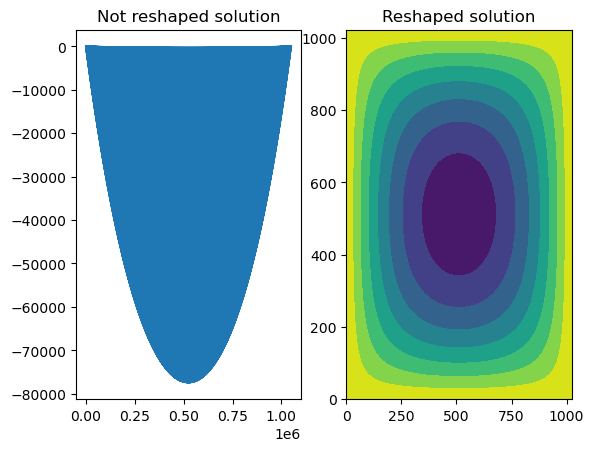

In [14]:
n = 1024
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csr_matrix(A)
rhs = np.ones(n * n)
sol = sp.sparse.linalg.spsolve(A, rhs)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(sol)
ax1.set_title('Not reshaped solution')
ax2.contourf(sol.reshape((n, n), order='f'))
ax2.set_title('Reshaped solution')

## Take home message

- About parallel matrix-by-vector product and different blocking.
- CSR format for storage
- Cache and parallel issues in sparse matrix processing
- Reordering and blocking as a way to solve these issues

# Questions?

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()